<a href="https://colab.research.google.com/github/WhiteHum/Medical-AI-Deep-Learning-Drug-Toxicitiy-Prediction-/blob/main/06_Covid_CT_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **공유폴더에 접근하기**

In [2]:
# 구글 드라이브ㅡ 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/06.Covid_CT_image_classification/Covid_Dataset.zip

Archive:  /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/06.Covid_CT_image_classification/Covid_Dataset.zip
   creating: Covid_Dataset/
  inflating: __MACOSX/._Covid_Dataset  
   creating: Covid_Dataset/Covid_Train/
  inflating: __MACOSX/Covid_Dataset/._Covid_Train  
  inflating: Covid_Dataset/.DS_Store  
  inflating: __MACOSX/Covid_Dataset/._.DS_Store  
   creating: Covid_Dataset/Covid_Test/
  inflating: __MACOSX/Covid_Dataset/._Covid_Test  
   creating: Covid_Dataset/Covid_Valid/
  inflating: __MACOSX/Covid_Dataset/._Covid_Valid  
   creating: Covid_Dataset/Covid_Train/1_CT_COVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Train/._1_CT_COVID  
   creating: Covid_Dataset/Covid_Train/0_CT_NonCOVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Train/._0_CT_NonCOVID  
   creating: Covid_Dataset/Covid_Test/1_CT_COVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Test/._1_CT_COVID  
   creating: Covid_Dataset/Covid_Test/0_CT_NonCOVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Test/._0_C

In [4]:
root_dir = '/content/Covid_Dataset'

# **데이터 준비 및 전처리**

### **이미지 예시 출력**

In [5]:
import random
import os
import cv2
import matplotlib.pyplot as plt

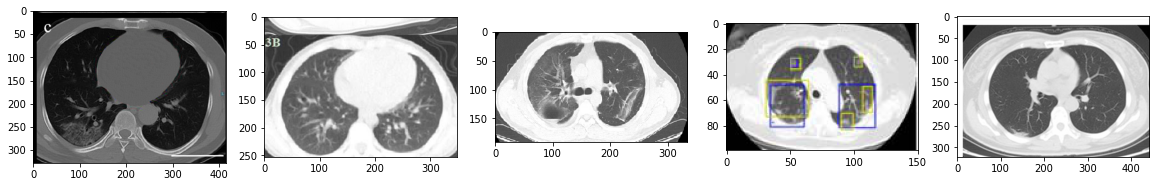

In [8]:
# Train data의 COVID 데이터 랜덤하게 5개 확인하기 (데이터 확인용)

covid_train_path = os.path.join(root_dir, 'Covid_Train', '1_CT_COVID')

covid_files = [os.path.join(covid_train_path, x) for x in os.listdir(covid_train_path)]
covid_images = [cv2.imread(x) for x in random.sample(covid_files, 5)]

# 이미지를 어떤 사이즈로 보여줄 것인지, 몇 열로 보여줄 것인지 설정하는 곳
plt.figure(figsize = (20, 10))
columns = 5

for i, image in enumerate(covid_images) :
  plt.subplot(len(covid_images) / columns + 1, columns, i +1)
  plt.imshow(image)
